The following code uses Aidan Scnieiders(off_conversion.py) and Trevor Susslands(mesh_file_converter.ip) code.

# File Format

The file format is `.npy` file with the shape of `[# of imgs, 64, 64, 3]` where the last array is in the range of 0 - 255. Example: `[[[255, 255, 255]]]` - a single image with a single black pixel.

Please Note I don't think the following is nessesary but I tried to use it for using Trimesh.save_image but there needs to be a display of some sort for it to work meaning that other things need to be installed on a sudo level which isn't possible on ROSIE.

Run the following in a terminal then run it inside of [Jupyter Notebook - Rosie](https://dh-ood.hpc.msoe.edu/pun/sys/dashboard/batch_connect/sys/rosie_jup_nb/session_contexts/new):  

`
conda create -n image_conversion python=3.9
conda activate image_conversion
pip install trimesh rtree pyglet==1.5.28 embree pyembree PyOpenGL pyrender pillow imageio matplotlib embreex pyvirtualdisplay
conda install -c anaconda libglu
conda install np_conda_kernels
conda install ipykernel
python -m ipykernel install --user --name=image_conversion
`

In [1]:
# !pip install trimesh
# !pip install rtree
# !pip install pyglet==1.5.28
# !pip install embreex
# !pip install pyembree
# !pip install PyOpenGl
# !pip install pyrender
# !pip install imageio
# !pip install pillow
# !pip install pyvirtualdisplay
# !conda install anaconda::libglu

In [1]:
import trimesh as tri
from trimesh import transformations
import numpy as np
import PIL.Image
import imageio
import math
import os
import glob
import pyglet
import pyrender
import io
import matplotlib.pyplot as plt
from pyvirtualdisplay import Display
from IPython.display import display
import scipy.io

# &#8595;&#8595; **IGNORE** &#8595;&#8595;

In [3]:
# train_stl = '/data/csc4801/KedzioraLab/ModelNet40/airplane/train/stl/airplane_0001.stl'
# mesh = tri.load(train_stl)
# scene = mesh.scene()
# display = Display(visible=0, size=(800, 600))
# display.start()
# image_buffer = scene.save_image(resolution=[64, 64], visible=False)
# display.stop()
# pil_image = Image.open(io.BytesIO(image_buffer))

# # Display the image using Matplotlib
# plt.imshow(pil_image)
# plt.axis('off')  # Turn off axes
# plt.show()

In [4]:
# # Load the STL file
# train_stl = '/data/csc4801/KedzioraLab/ModelNet40/airplane/train/stl/airplane_0001.stl'
# mesh = tri.load(train_stl)

# # Create a scene with the mesh
# scene = mesh.scene()

# # Create a renderer
# renderer = pyrender.OffscreenRenderer(viewport_width=800, viewport_height=600)

# # Render the scene
# color, depth = renderer.render(scene)

# # Convert the color buffer to numpy array
# image_array = np.flipud(color)

# # Now you have the rendered image in numpy format, you can manipulate or save it as needed
# # For example, to save it as a .npy file:
# # np.save('rendered_image.npy', image_array)
# print(image_array)

# &#8593;&#8593; **IGNORE** &#8593;&#8593;

## Useful Code

In [5]:
def generate_color_image(mesh, rotation):
    angle = rotation
    direction = [0, 1, 0]
    center = [0, 0, 0]

    rot_matrix = transformations.rotation_matrix(angle, direction, center)

    mesh.apply_transform(rot_matrix)

    scene = mesh.scene()

    scene.camera.resolution = [1024, 1024]

    scene.camera.fov = 60 * (scene.camera.resolution / scene.camera.resolution.max())

    origins, vectors, pixels = scene.camera_rays()

    faces, index_rays = tri.ray.ray_pyembree.RayMeshIntersector(mesh).intersects_id(ray_origins=origins, ray_directions=vectors, multiple_hits=False)

    image_data = np.zeros((scene.camera.resolution[1], scene.camera.resolution[0], 3), dtype=np.float64)

    for face, index_ray in zip(faces, index_rays):
        image_data[pixels[index_ray, 0], pixels[index_ray, 1]] = mesh.visual.mesh.visual.face_colors[face][:3]
    
    #     # Define the downsampling factor
    downsampling_factor = 1024 // 64
    
    # Reshape the image into blocks
    blocks = image_data.reshape(64, downsampling_factor, 64, downsampling_factor, 3)

    # Take the average over each block
    image_data = blocks.mean(axis=(1, 3))
    
    image_data /= 255
    return 2 * image_data - 1
    
#     # Display the image using Matplotlib
#     plt.imshow(image_data)
#     plt.axis('off')  # Turn off axes
#     plt.show()


# train_stl = '/data/csc4801/KedzioraLab/ModelNet40/stairs/train/stl/stairs_0012.stl'
# mesh = tri.load(train_stl)

# generate_color_image(mesh, 0)
# generate_color_image(mesh, 0)
# generate_color_image(mesh, 1)
# generate_color_image(mesh, 2)

In [6]:
def generate_depth_map(mesh, rotation):

    angle = rotation
    direction = [0, 1, 0]
    center = [0, 0, 0]

    rot_matrix = transformations.rotation_matrix(angle, direction, center)

    mesh.apply_transform(rot_matrix)
    
    # scene will have automatically generated camera and lights
    scene = mesh.scene()

    # any of the automatically generated values can be overridden
    # set resolution, in pixels
    scene.camera.resolution = [1024, 1024]
    # set field of view, in degrees
    # make it relative to resolution so pixels per degree is same
    scene.camera.fov = 60 * (scene.camera.resolution / scene.camera.resolution.max())

    # convert the camera to rays with one ray per pixel
    origins, vectors, pixels = scene.camera_rays()

    # do the actual ray- mesh queries
    points, index_ray, index_tri = mesh.ray.intersects_location(
        origins, vectors, multiple_hits=False
    )

    # for each hit, find the distance along its vector
    depth = tri.util.diagonal_dot(points - origins[0], vectors[index_ray])
    # find pixel locations of actual hits
    pixel_ray = pixels[index_ray]

    # create a numpy array we can turn into an image
    # doing it with uint8 creates an `L` mode greyscale image
    a = np.zeros(scene.camera.resolution, dtype=np.float64)

    # scale depth against range (0.0 - 1.0)
    depth_float = (depth - depth.min()) / depth.ptp()

    # convert depth into 0 - 255 uint8
    depth_int = (depth_float * 255).round().astype(np.uint8)
    # assign depth to correct pixel locations
    a[pixel_ray[:, 0], pixel_ray[:, 1]] = depth_int

#     # Define the downsampling factor
    downsampling_factor = 1024 // 64

    # Reshape the image into blocks
    blocks = a.reshape(64, downsampling_factor, 64, downsampling_factor)

    # Take the average over each block
    a = blocks.mean(axis=(1, 3))

    a /= 255
    return 2 * a - 1

#     # create a PIL image from the depth queries
#     img = PIL.Image.fromarray(a)

#     # Display the image using Matplotlib
#     plt.imshow(img)
#     plt.axis('off')  # Turn off axes
#     plt.show()
    
# train_stl = '/data/csc4801/KedzioraLab/ModelNet40/airplane/train/stl/airplane_0001.stl'
# mesh = tri.load(train_stl)

# generate_depth_map(mesh, 0)
# # generate_depth_map(mesh, 1)
# # generate_depth_map(mesh, 2)
# # generate_depth_map(mesh, 3)

# Work in progress

In [ ]:
base_directory = '/data/csc4801/KedzioraLab/ModelNet40/'

try:
    for category in os.listdir(base_directory):
        category_path = os.path.join(base_directory, category)
        
        if os.path.isdir(category_path):
            for train_test in os.listdir(category_path):
                current_dir = os.path.join(category_path, train_test)
                img_dir = os.path.join(current_dir, 'image')
                dpth_dir = os.path.join(current_dir, 'depth')
                stl_dir = os.path.join(current_dir, 'stl')

                if not os.path.exists(img_dir):
                    os.makedirs(img_dir)
                if not os.path.exists(dpth_dir):
                    os.makedirs(dpth_dir)
                if not os.path.exists(stl_dir):
                    os.makedirs(stl_dir)

                stl_files_pattern = os.path.join(stl_dir, '*.stl')

                for stl_file in glob.glob(stl_files_pattern):
                    print(f'Processing {stl_file}')
                    filename = stl_file.split('.')[0].split('/')[-1]

                    img_file_path = os.path.join(img_dir, f'{filename}.npy')
                    dpth_file_path = os.path.join(dpth_dir, f'{filename}.npy')

                    try:
                        images = []
                        depths = []
                        
                        mesh = tri.load_mesh(stl_file)
                        
                        angle = np.pi/8
                        direction = [1, 0, 0]
                        center = [0, 0, 0]

                        rot_matrix = transformations.rotation_matrix(angle, direction, center)

                        mesh.apply_transform(rot_matrix)
                        
                        depths.append(generate_depth_map(mesh, 0))
                        images.append(generate_color_image(mesh, 0))
                        for i in range(0, 23):
                            depths.append(generate_depth_map(mesh, math.pi * 2/24))
                            images.append(generate_color_image(mesh, math.pi * 2/24))
                        
                        np.save(dpth_file_path, np.array(depths))
                        np.save(img_file_path, np.array(images))
                    except Exception as e:
                        print(f"Error converting {stl_file}: {e}")

except (FileNotFoundError, PermissionError) as e:
    print(f"Error accessing files: {e}")

Processing /data/csc4801/KedzioraLab/ModelNet40/stairs/train/stl/stairs_0011.stl
Processing /data/csc4801/KedzioraLab/ModelNet40/stairs/train/stl/stairs_0013.stl
Processing /data/csc4801/KedzioraLab/ModelNet40/stairs/train/stl/stairs_0090.stl
Processing /data/csc4801/KedzioraLab/ModelNet40/stairs/train/stl/stairs_0070.stl
Processing /data/csc4801/KedzioraLab/ModelNet40/stairs/train/stl/stairs_0099.stl
Processing /data/csc4801/KedzioraLab/ModelNet40/stairs/train/stl/stairs_0033.stl
Processing /data/csc4801/KedzioraLab/ModelNet40/stairs/train/stl/stairs_0061.stl


In [2]:
def quaternionFromYawPitchRoll(yaw,pitch,roll):
    c1 = np.cos(yaw/2.0)
    c2 = np.cos(pitch/2.0)
    c3 = np.cos(roll/2.0)
    s1 = np.sin(yaw/2.0)
    s2 = np.sin(pitch/2.0)
    s3 = np.sin(roll/2.0)
    qa = c1*c2*c3+s1*s2*s3
    qb = c1*c2*s3-s1*s2*c3
    qc = c1*s2*c3+s1*c2*s3
    qd = s1*c2*c3-c1*s2*s3
    return [qa,qb,qc,qd]

def quaternionProduct(q1,q2): 
    qa = q1[0]*q2[0]-q1[1]*q2[1]-q1[2]*q2[2]-q1[3]*q2[3]
    qb = q1[0]*q2[1]+q1[1]*q2[0]+q1[2]*q2[3]-q1[3]*q2[2]
    qc = q1[0]*q2[2]-q1[1]*q2[3]+q1[2]*q2[0]+q1[3]*q2[1]
    qd = q1[0]*q2[3]+q1[1]*q2[2]-q1[2]*q2[1]+q1[3]*q2[0]
    return [qa,qb,qc,qd]

def rotMatrixToQuaternion(R):
    t = R[0,0]+R[1,1]+R[2,2]
    r = np.sqrt(1+t)
    qa = 0.5*r
    qb = np.sign(R[2,1]-R[1,2])*np.abs(0.5*np.sqrt(1+R[0,0]-R[1,1]-R[2,2]))
    qc = np.sign(R[0,2]-R[2,0])*np.abs(0.5*np.sqrt(1-R[0,0]+R[1,1]-R[2,2]))
    qd = np.sign(R[1,0]-R[0,1])*np.abs(0.5*np.sqrt(1-R[0,0]-R[1,1]+R[2,2]))
    return [qa,qb,qc,qd]

def quaternionToRotMatrix(q):
    R = np.array([[1-2*(q[2]**2+q[3]**2),2*(q[1]*q[2]-q[0]*q[3]),2*(q[0]*q[2]+q[1]*q[3])],
                  [2*(q[1]*q[2]+q[0]*q[3]),1-2*(q[1]**2+q[3]**2),2*(q[2]*q[3]-q[0]*q[1])],
                  [2*(q[1]*q[3]-q[0]*q[2]),2*(q[0]*q[1]+q[2]*q[3]),1-2*(q[1]**2+q[2]**2)]])
    return R

def randomRotation():
    pos = np.inf
    while np.linalg.norm(pos)>1:
        pos = np.random.rand(3)*2-1
    pos /= np.linalg.norm(pos)
    phi = np.arcsin(pos[2])
    theta = np.arccos(pos[0]/np.cos(phi))
    if pos[1]<0: theta = 2*np.pi-theta
    elev = np.rad2deg(phi)
    azim = np.rad2deg(theta)
    rho = 1
    theta = np.random.rand()*360
    return rho,azim,elev,theta

def camPosToQuaternion(camPos):
    [cx,cy,cz] = camPos
    q1 = [0,0,np.sqrt(2)/2,np.sqrt(2)/2]
    camDist = np.linalg.norm([cx,cy,cz])
    cx,cy,cz = cx/camDist,cy/camDist,cz/camDist
    t = np.linalg.norm([cx,cy])
    tx,ty = cx/t,cy/t
    yaw = np.arccos(ty) 
    yaw = 2*np.pi-np.arccos(ty) if tx>0 else yaw
    pitch = 0
    roll = np.arccos(np.clip(tx*cx+ty*cy,-1,1))
    roll = -roll if cz<0 else roll
    q2 = quaternionFromYawPitchRoll(yaw,pitch,roll)	
    q3 = quaternionProduct(q2,q1)
    return q3

In [3]:
camPosAll = np.array([[1,1,1],[1,-1,-1],[-1,1,-1],[-1,-1,1],[1,1,-1],[1,-1,1],[-1,1,1],[-1,-1,-1]],dtype=float)
camPosAll /= np.sqrt(3)
eightPoint = [camPosToQuaternion(camPos) for camPos in camPosAll]

In [19]:
train_stl = '/data/csc4801/KedzioraLab/ModelNet40/airplane/train/stl/airplane_0001.stl'
mesh = tri.load(train_stl)

angle = np.pi/4
direction = [0.2, 0.5, 0.5]
center = [0, 0, 0]

rot_matrix = transformations.rotation_matrix(angle, direction, center)
print(rot_matrix)
print(quaternionToRotMatrix(rotMatrixToQuaternion(rot_matrix)))
# mesh.apply_transform(quaternionToRotMatrix())

[[ 0.72880258 -0.42688574  0.53536471  0.        ]
 [ 0.53536471  0.84270549 -0.05685138  0.        ]
 [-0.42688574  0.3280488   0.84270549  0.        ]
 [ 0.          0.          0.          1.        ]]
[[ 0.72880258 -0.42688574  0.53536471]
 [ 0.53536471  0.84270549 -0.05685138]
 [-0.42688574  0.3280488   0.84270549]]


In [4]:
import trimesh as tri
from trimesh import transformations
import numpy as np
import PIL.Image
import imageio
import math
import os
import glob
import pyglet
import pyrender
import io
import matplotlib.pyplot as plt
from pyvirtualdisplay import Display
from IPython.display import display
import argparse
import scipy.io
import sys
import util
import multiprocessing as mp

In [5]:
def quaternionFromYawPitchRoll(yaw,pitch,roll):
    c1 = np.cos(yaw/2.0)
    c2 = np.cos(pitch/2.0)
    c3 = np.cos(roll/2.0)
    s1 = np.sin(yaw/2.0)
    s2 = np.sin(pitch/2.0)
    s3 = np.sin(roll/2.0)
    qa = c1*c2*c3+s1*s2*s3
    qb = c1*c2*s3-s1*s2*c3
    qc = c1*s2*c3+s1*c2*s3
    qd = s1*c2*c3-c1*s2*s3
    return [qa,qb,qc,qd]


def quaternionProduct(q1,q2):
    qa = q1[0]*q2[0]-q1[1]*q2[1]-q1[2]*q2[2]-q1[3]*q2[3]
    qb = q1[0]*q2[1]+q1[1]*q2[0]+q1[2]*q2[3]-q1[3]*q2[2]
    qc = q1[0]*q2[2]-q1[1]*q2[3]+q1[2]*q2[0]+q1[3]*q2[1]
    qd = q1[0]*q2[3]+q1[1]*q2[2]-q1[2]*q2[1]+q1[3]*q2[0]
    return [qa,qb,qc,qd]


def rotMatrixToQuaternion(R):
    t = R[0,0]+R[1,1]+R[2,2]
    r = np.sqrt(1+t)
    qa = 0.5*r
    qb = np.sign(R[2,1]-R[1,2])*np.abs(0.5*np.sqrt(1+R[0,0]-R[1,1]-R[2,2]))
    qc = np.sign(R[0,2]-R[2,0])*np.abs(0.5*np.sqrt(1-R[0,0]+R[1,1]-R[2,2]))
    qd = np.sign(R[1,0]-R[0,1])*np.abs(0.5*np.sqrt(1-R[0,0]-R[1,1]+R[2,2]))
    return [qa,qb,qc,qd]


def quaternionToRotMatrix(q):
    R = np.array([[1-2*(q[2]**2+q[3]**2),2*(q[1]*q[2]-q[0]*q[3]),2*(q[0]*q[2]+q[1]*q[3]), 0],
                  [2*(q[1]*q[2]+q[0]*q[3]),1-2*(q[1]**2+q[3]**2),2*(q[2]*q[3]-q[0]*q[1]), 0],
                  [2*(q[1]*q[3]-q[0]*q[2]),2*(q[0]*q[1]+q[2]*q[3]),1-2*(q[1]**2+q[2]**2), 0],
                  [0, 0, 0, 1]])
    return R


def randomRotation():
    pos = np.inf
    while np.linalg.norm(pos)>1:
        pos = np.random.rand(3)*2-1
    pos /= np.linalg.norm(pos)
    phi = np.arcsin(pos[2])
    theta = np.arccos(pos[0]/np.cos(phi))
    if pos[1]<0: theta = 2*np.pi-theta
    elev = np.rad2deg(phi)
    azim = np.rad2deg(theta)
    rho = 1
    theta = np.random.rand()*360
    return [rho,azim,elev,theta]


def camPosToQuaternion(camPos):
    [cx,cy,cz] = camPos
    q1 = [0,0,np.sqrt(2)/2,np.sqrt(2)/2]
    camDist = np.linalg.norm([cx,cy,cz])
    cx,cy,cz = cx/camDist,cy/camDist,cz/camDist
    t = np.linalg.norm([cx,cy])
    tx,ty = cx/t,cy/t
    yaw = np.arccos(ty)
    yaw = 2*np.pi-np.arccos(ty) if tx>0 else yaw
    pitch = 0
    roll = np.arccos(np.clip(tx*cx+ty*cy,-1,1))
    roll = -roll if cz<0 else roll
    q2 = quaternionFromYawPitchRoll(yaw,pitch,roll)
    q3 = quaternionProduct(q2,q1)
    return q3

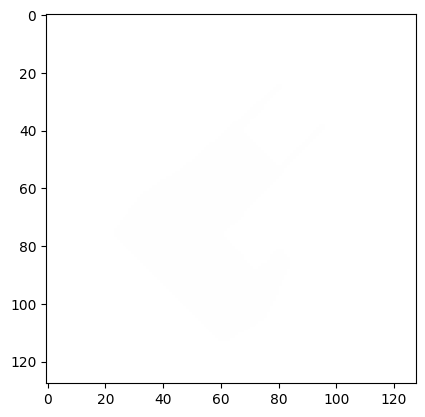

In [17]:
def generate_depth_map(mesh, rotation_matrix):
    mesh.apply_transform(rotation_matrix)

    # scene will have automatically generated camera and lights
    scene = mesh.scene()

    # any of the automatically generated values can be overridden
    # set resolution, in pixels
    scene.camera.resolution = [128, 128]
    # set field of view, in degrees
    # make it relative to resolution so pixels per degree is same
    scene.camera.fov = 60 * (scene.camera.resolution / scene.camera.resolution.max())

    # convert the camera to rays with one ray per pixel
    origins, vectors, pixels = scene.camera_rays()

    # do the actual ray- mesh queries
    points, index_ray, index_tri = mesh.ray.intersects_location(
        origins, vectors, multiple_hits=False
    )

    # for each hit, find the distance along its vector
    depth = tri.util.diagonal_dot(points - origins[0], vectors[index_ray])
    # find pixel locations of actual hits
    pixel_ray = pixels[index_ray]

    # create a numpy array we can turn into an image
    # doing it with uint8 creates an `L` mode greyscale image
    a = np.zeros(scene.camera.resolution, dtype=np.float64)

    # scale depth against range (0.0 - 1.0)
    depth_float = (depth - depth.min()) / depth.ptp()

    # convert depth into 0 - 255 uint8
    depth_int = (depth_float * 255).round().astype(np.uint8)
    # assign depth to correct pixel locations
    a[pixel_ray[:, 0], pixel_ray[:, 1]] = depth_int

    # # Define the downsampling factor
    # downsampling_factor = 128 // 128
    #
    # # Reshape the image into blocks
    # blocks = a.reshape(128, downsampling_factor, 128, downsampling_factor)
    #
    # # Take the average over each block
    # a = blocks.mean(axis=(1, 3))

#     a1 = []
#     for p in a:
#         r = []
        
        
    
#     # Display the image using Matplotlib
#     plt.imshow(a)
#     plt.axis('off')  # Turn off axes
#     plt.show()
    tmp = a

    tmp1 = []
    for a in tmp:
        r = []
        for b in a:
            r.append([b, b, b])
        tmp1.append(r)
    tmp1 = np.array(tmp1)
    return tmp1

#     a /= 255
#     return 2 * a - 1

def generate_color_image(mesh, rotation_matrix):
    mesh.apply_transform(rotation_matrix)

    scene = mesh.scene()

    scene.camera.resolution = [64, 64]

    scene.camera.fov = 60 * (scene.camera.resolution / scene.camera.resolution.max())

    origins, vectors, pixels = scene.camera_rays()

    faces, index_rays = tri.ray.ray_pyembree.RayMeshIntersector(mesh).intersects_id(ray_origins=origins,
                                                                                    ray_directions=vectors,
                                                                                    multiple_hits=False)

    image_data = np.zeros((scene.camera.resolution[1], scene.camera.resolution[0], 3), dtype=np.float64)

    for face, index_ray in zip(faces, index_rays):
        image_data[pixels[index_ray, 0], pixels[index_ray, 1]] = mesh.visual.mesh.visual.face_colors[face][:3]

    # #     # Define the downsampling factor
    # downsampling_factor = 256 // 64
    #
    # # Reshape the image into blocks
    # blocks = image_data.reshape(64, downsampling_factor, 64, downsampling_factor, 3)
    #
    # # Take the average over each block
    # image_data = blocks.mean(axis=(1, 3))

#     image_data /= 255
#     return image_data

    # Display the image using Matplotlib
    plt.imshow(image_data)
    plt.axis('off')  # Turn off axes
    plt.show()


train_stl = '/data/csc4801/KedzioraLab/ModelNet40/stairs/train/stl/stairs_0011.stl'
mesh = tri.load(train_stl)

cam_pos_all = np.array(
        [[1, 1, 1], [1, -1, -1], [-1, 1, -1], [-1, -1, 1], [1, 1, -1], [1, -1, 1], [-1, 1, 1], [-1, -1, -1]],
        dtype=float)
cam_pos_all /= np.sqrt(3)
eight_point = np.array([quaternionToRotMatrix(camPosToQuaternion(cam_pos)) for cam_pos in cam_pos_all])


# tmp = generate_depth_map(mesh, eight_point[7])
tmp = generate_depth_map(mesh, eight_point[6])/-255 + 1
plt.imshow(tmp)
plt.show()
# generate_color_image(mesh, 0)
# generate_color_image(mesh, 1)
# generate_color_image(mesh, 2)

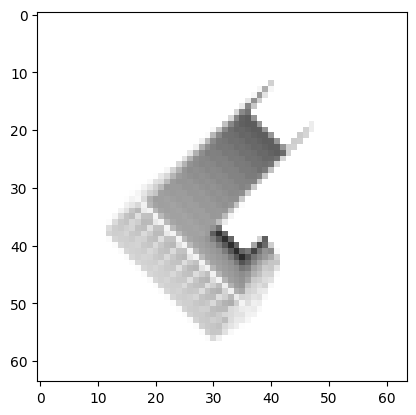

In [28]:
train_stl = '/data/csc4801/KedzioraLab/ModelNet40/stairs/train/stl/stairs_0011.stl'
mesh = tri.load(train_stl)

cam_pos_all = np.array(
        [[1, 1, 1], [1, -1, -1], [-1, 1, -1], [-1, -1, 1], [1, 1, -1], [1, -1, 1], [-1, 1, 1], [-1, -1, -1]],
        dtype=float)
cam_pos_all /= np.sqrt(3)
eight_point = np.array([quaternionToRotMatrix(camPosToQuaternion(cam_pos)) for cam_pos in cam_pos_all])

rotation_matrix = eight_point[6]

mesh.apply_transform(rotation_matrix)

# scene will have automatically generated camera and lights
scene = mesh.scene()

# any of the automatically generated values can be overridden
# set resolution, in pixels
scene.camera.resolution = [256, 256]
# set field of view, in degrees
# make it relative to resolution so pixels per degree is same
scene.camera.fov = 60 * (scene.camera.resolution / scene.camera.resolution.max())

# convert the camera to rays with one ray per pixel
origins, vectors, pixels = scene.camera_rays()

# do the actual ray- mesh queries
points, index_ray, index_tri = mesh.ray.intersects_location(
    origins, vectors, multiple_hits=False
)

# for each hit, find the distance along its vector
depth = tri.util.diagonal_dot(points - origins[0], vectors[index_ray])
# find pixel locations of actual hits
pixel_ray = pixels[index_ray]

# create a numpy array we can turn into an image
# doing it with uint8 creates an `L` mode greyscale image
a = np.zeros(scene.camera.resolution, dtype=np.float64)

# scale depth against range (0.0 - 1.0)
depth_float = (depth - depth.min()) / depth.ptp()

# convert depth into 0 - 255 uint8
depth_int = (depth_float * 255).round().astype(np.uint8)
# assign depth to correct pixel locations
a[pixel_ray[:, 0], pixel_ray[:, 1]] = depth_int

downsampling_factor = scene.camera.resolution[0] // 64

# Reshape the image into blocks
blocks = a.reshape(64, downsampling_factor, 64, downsampling_factor)

# Take the average over each block
a = blocks.mean(axis=(1, 3))

tmp = a

tmp1 = []
for a in tmp:
    r = []
    for b in a:
        r.append([b, b, b])
    tmp1.append(r)
tmp1 = np.array(tmp1)

tmp = tmp1/-255 + 1
plt.imshow(tmp)
plt.show()

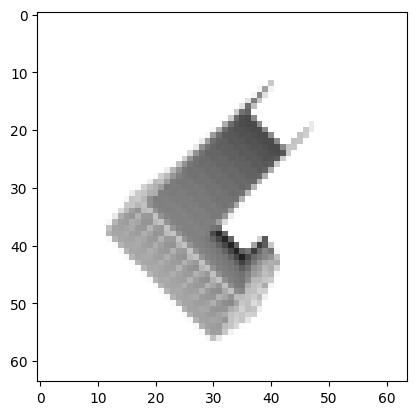

In [29]:
train_stl = '/data/csc4801/KedzioraLab/ModelNet40/stairs/train/stl/stairs_0011.stl'
mesh = tri.load(train_stl)

cam_pos_all = np.array(
        [[1, 1, 1], [1, -1, -1], [-1, 1, -1], [-1, -1, 1], [1, 1, -1], [1, -1, 1], [-1, 1, 1], [-1, -1, -1]],
        dtype=float)
cam_pos_all /= np.sqrt(3)
eight_point = np.array([quaternionToRotMatrix(camPosToQuaternion(cam_pos)) for cam_pos in cam_pos_all])

rotation_matrix = eight_point[6]

mesh.apply_transform(rotation_matrix)

scene = mesh.scene()

scene.camera.resolution = [256, 256]
scene.camera.fov = 60 * (scene.camera.resolution / scene.camera.resolution.max())

origins, vectors, pixels = scene.camera_rays()

points, index_ray, index_tri = mesh.ray.intersects_location(
    origins, vectors, multiple_hits=False
)

depth = tri.util.diagonal_dot(points - origins[0], vectors[index_ray])
pixel_ray = pixels[index_ray]

a = np.zeros(scene.camera.resolution, dtype=np.float64)

depth_float = (depth - depth.min()) / depth.ptp()

depth_scaled = 0.8 * (depth_float - depth_float.min()) / depth_float.ptp() + 0.2

depth_int_scaled = (depth_scaled * 255).round().astype(np.uint8)
a[pixel_ray[:, 0], pixel_ray[:, 1]] = depth_int_scaled

downsampling_factor = scene.camera.resolution[0] // 64

# Reshape the image into blocks
blocks = a.reshape(64, downsampling_factor, 64, downsampling_factor)

# Take the average over each block
a = blocks.mean(axis=(1, 3))

tmp = a

tmp1 = []
for a_row in tmp:
    r = []
    for b in a_row:
        r.append([b, b, b])
    tmp1.append(r)
tmp1 = np.array(tmp1)

tmp = tmp1/-255 + 1
plt.imshow(tmp)
plt.show()

In [22]:
tmp

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

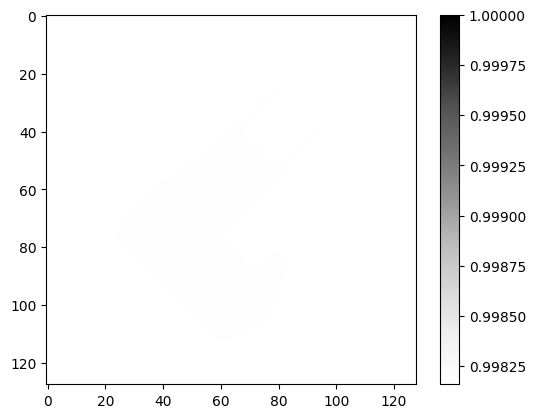

In [15]:
fig, ax = plt.subplots()
h = ax.imshow(tmp, cmap = 'Greys')
fig.colorbar(h)
fig.show()

In [10]:
tmp

array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       ...,

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]])

In [ ]:
train_stl = '/data/csc4801/KedzioraLab/ModelNet40/airplane/train/stl/airplane_0001.stl'
mesh = tri.load(train_stl)
rot_matrix = transformations.rotation_matrix(angle, direction, center)

In [49]:
tmp1 = []
for a in tmp:
    r = []
    for b in a:
        r.append([b, b, b])
    tmp1.append(r)
tmp1 = np.array(tmp1)

In [50]:
np.unique(tmp1)

array([  0.,   1.,   2.,   3.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  22.,  23.,
        24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,
        35.,  36.,  38.,  39.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,
        49.,  50.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,
        61.,  62.,  64.,  65.,  67.,  68.,  71.,  72.,  73.,  74.,  75.,
        76.,  77.,  78.,  79.,  80.,  81.,  83.,  84.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  96.,  97.,  99., 100., 101.,
       103., 105., 107., 108., 111., 112., 113., 114., 115., 117., 118.,
       119., 122., 123., 124., 125., 126., 127., 128., 129., 131., 132.,
       135., 136., 137., 138., 139., 140., 141., 142., 143., 144., 147.,
       150., 151., 152., 153., 154., 155., 156., 157., 158., 160., 168.,
       169., 170., 171., 172., 173., 174., 176., 178., 180., 183., 186.,
       187., 188., 189., 190., 191., 192., 194., 19

In [54]:
np.unique(tmp1)

array([  0.,   1.,   2.,   3.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  22.,  23.,
        24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,
        35.,  36.,  38.,  39.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,
        49.,  50.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,
        61.,  62.,  64.,  65.,  67.,  68.,  71.,  72.,  73.,  74.,  75.,
        76.,  77.,  78.,  79.,  80.,  81.,  83.,  84.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  96.,  97.,  99., 100., 101.,
       103., 105., 107., 108., 111., 112., 113., 114., 115., 117., 118.,
       119., 122., 123., 124., 125., 126., 127., 128., 129., 131., 132.,
       135., 136., 137., 138., 139., 140., 141., 142., 143., 144., 147.,
       150., 151., 152., 153., 154., 155., 156., 157., 158., 160., 168.,
       169., 170., 171., 172., 173., 174., 176., 178., 180., 183., 186.,
       187., 188., 189., 190., 191., 192., 194., 19

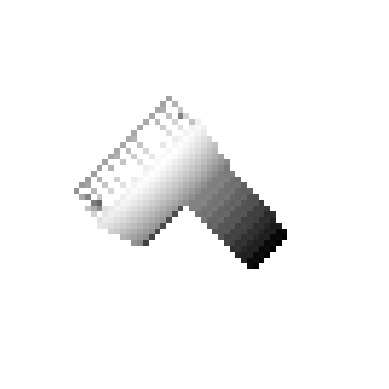

In [56]:
plt.imshow(tmp1/-255 + 1)
plt.axis('off')  # Turn off axes
plt.show()